# Part 1: Evaluating Adorno and Horkheimer's Claim

Adorno and Horkheimer claim that "Culture today is infecting everything with sameness". The authors lament that the commoditization of cultural production separates individuals from their innate creativity and imagination, turning them instead into consumers. In this project, I will investigate their claims of cultural homogenization by exploring trends in music production and consumption as operationalized by the Billboard 100's top 100 songs from the 1950s to the 2010s.

To Adorno and Horkheimer, cultural production has come under complete control of commercial imperatives, the need to maximise profits by increasing consumption. The process of production is mechanized to serve the aspects of the consumer most conducive to revenue growth. Consumers are fed a false sense of individuality, masked by pre-defined market segmentations that give the illusion of freedom of choice.

Songs might use different words and beats but are produced in with the same schemes and formulas and for the same purpose. Nothing radical is ever created by a production process more content to recycle pre-existing conventions in differing permutations and combinations. The consumer is lulled into a state of comfort by the predictability of each hit song.

To evaluate this claim, I explore the features of songs from the Billboard 100 to determine if there are observable changes in their content over time. I first examine changes in standard deviation across the different features of the Billboard 100. If culture is indeed becoming homogenized, we should observe decreases in standard deviations across certain metrics as represented by the line of best fit.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import nltk
import string
from gensim import corpora, models
import music
import numpy as np
from scipy.stats import pearsonr

In [2]:
#load in music_df
music_df = pd.read_csv('music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)

In [3]:
#Loading in all music data averages (will elaborate on dataset later)
music_avg_df = pd.read_csv("data_by_year.csv")
music_avg_df = music_avg_df[(music_avg_df["year"] >= 1950) &
                            (music_avg_df["year"] <= 2015) ]
music_avg_df["year_bin"] = music_avg_df['year'].apply(lambda x: str(x)[0:3] + "0s")

## Exploring changes in standard deviation

If culture is becoming homogenized, there should be less variance in its content over time. Songs in the Billboard 100 should converge to the mean, resulting in a decrease in standard deviation.

### Examining Text Content of Music

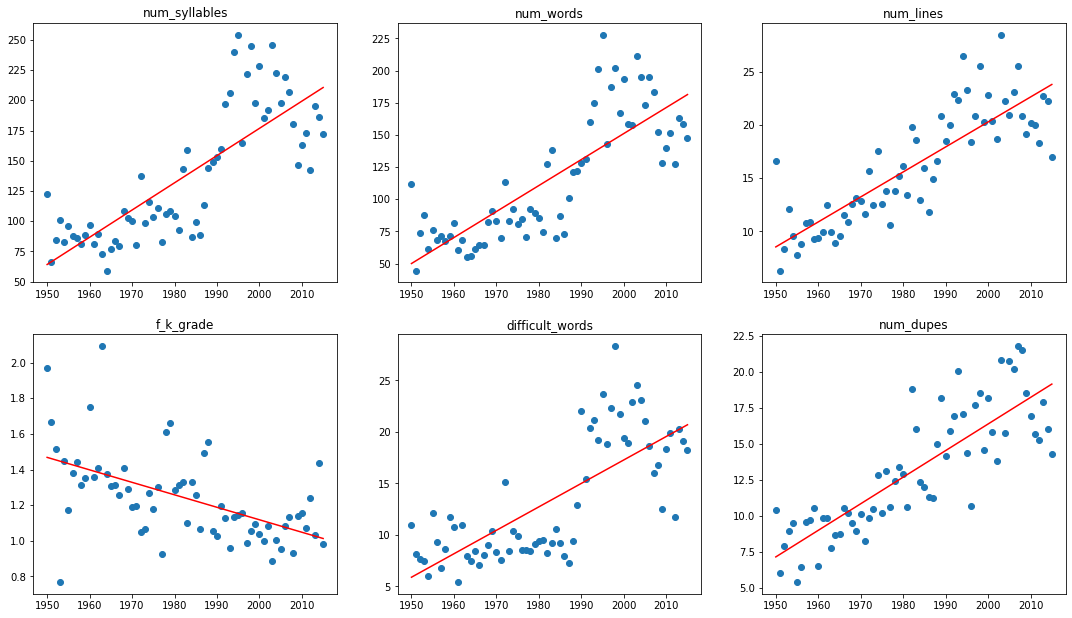

In [4]:
#These functions take columns from a datframe and generate time series scatter plots with a line of best fit

text_columns = ["num_syllables",
                "num_words",
                "num_lines",
                "f_k_grade",
                "difficult_words",
                "num_dupes"]

def best_fit_line(X, dv, r, c, df, axs):
        Y = np.array(df.groupby("year")[dv].std())
        theta = np.polyfit(X, Y, 1)
        y_line = theta[1] + theta[0] * X
        axs[r, c].scatter(X, Y)
        axs[r, c].plot(X, y_line, 'r')
        axs[r, c].set_title(dv)
        
def music_plots(columns, row, colnum, df):
    fig, axs = plt.subplots(nrows=row, ncols=colnum)
    fig.set_size_inches(18.5, 10.5)
    X = np.array(df["year"].unique())
    r = 0
    c = 0 
    for col in columns:
        if c <= colnum - 1:
            best_fit_line(X, col, r, c, df, axs)
            c += 1
        else:
            c = 0
            r += 1
            best_fit_line(X, col, r, c, df, axs)
            c += 1 
            
music_plots(text_columns, 2, 3, music_df)

My analysis of the textual content of Billboard 100 songs reveals that only the standard deviation of the Flesch-Kincaid readability test has been decreasing since 1950. This indicates homogenization in the complexity of song lyrics. However, other metrics such as the number of difficult words demonstrate increasing standard deviations which weakens the validity of these findings.

### Audio Content of Billboard 100 Music

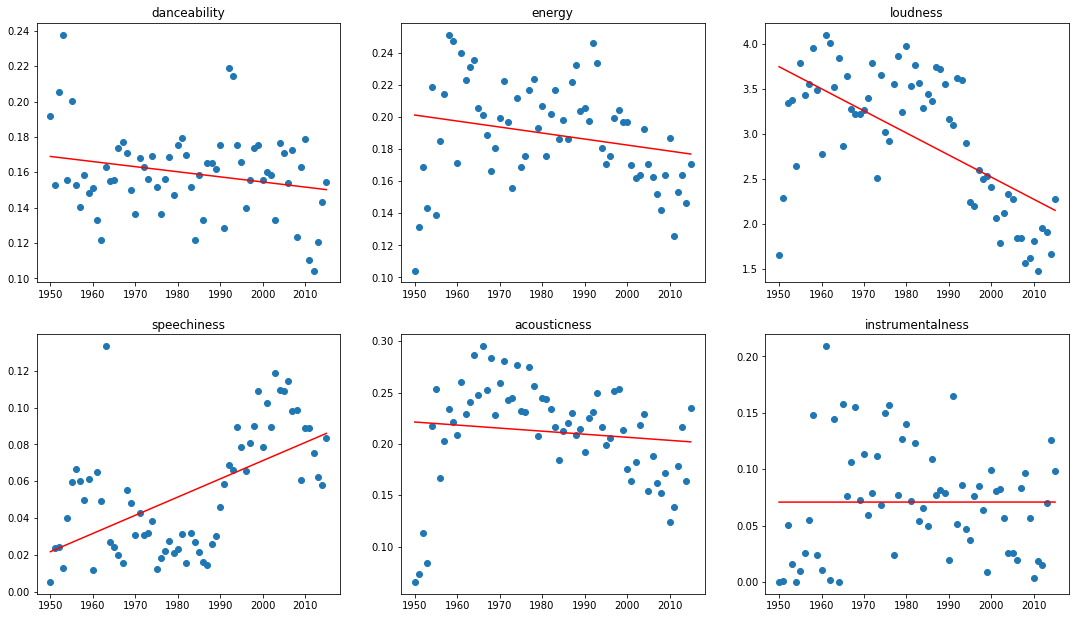

In [5]:
music_columns = ["danceability",
                "energy",
                "loudness",
                "speechiness",
                "acousticness",
                "instrumentalness"]
music_plots(music_columns, 2, 3, music_df)

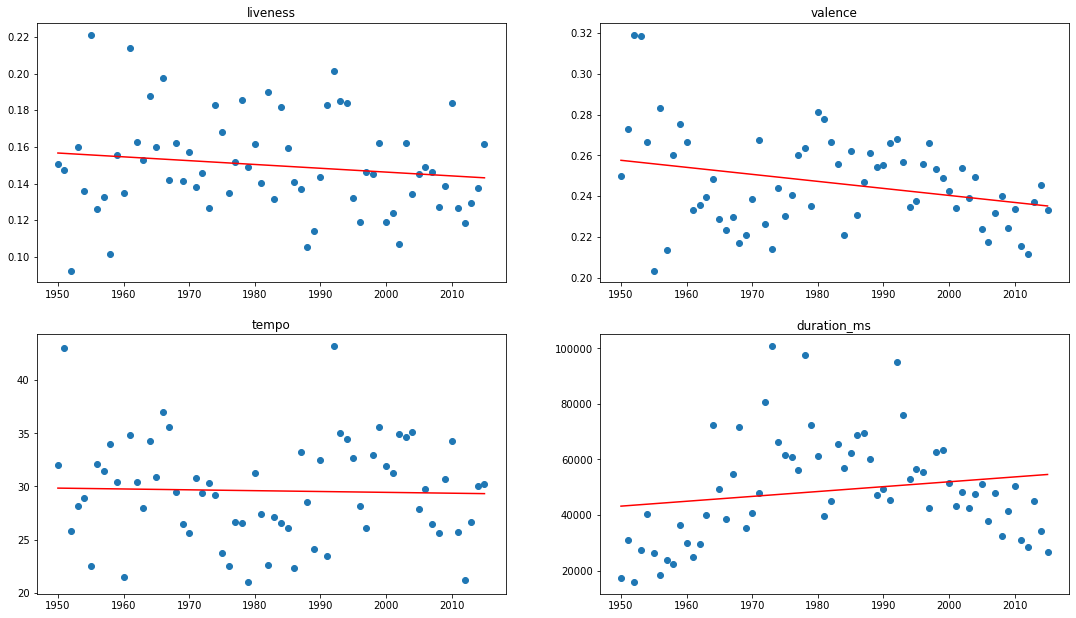

In [6]:
#next set of audio features
music_columns_2 = ["liveness",
                   "valence",
                   "tempo",
                   "duration_ms"]
music_plots(music_columns_2, 2, 2, music_df)

My analysis of audio content shows strong declines in standard deviation for loudness and weak declines for danceability, energy, liveness, and valence. Obtaining definite proof of homogenization across these dimensions will require further analysis.

## Comparing variations across clusters

To scrutinize the above variations in musical content I plot the means of each feature across time, grouped by clusters. This will allow me to see if the distinct “string lover” and “poetic” clusters are converging in similarity thus lending credence to Adorno and Horkheimer’s claims of homogenization masked by superficial diversity. Based on the best fit lines, I can observe convergence across Flesh-Kincaid readability, energy, speechiness, acousticness, valence, and duration. 

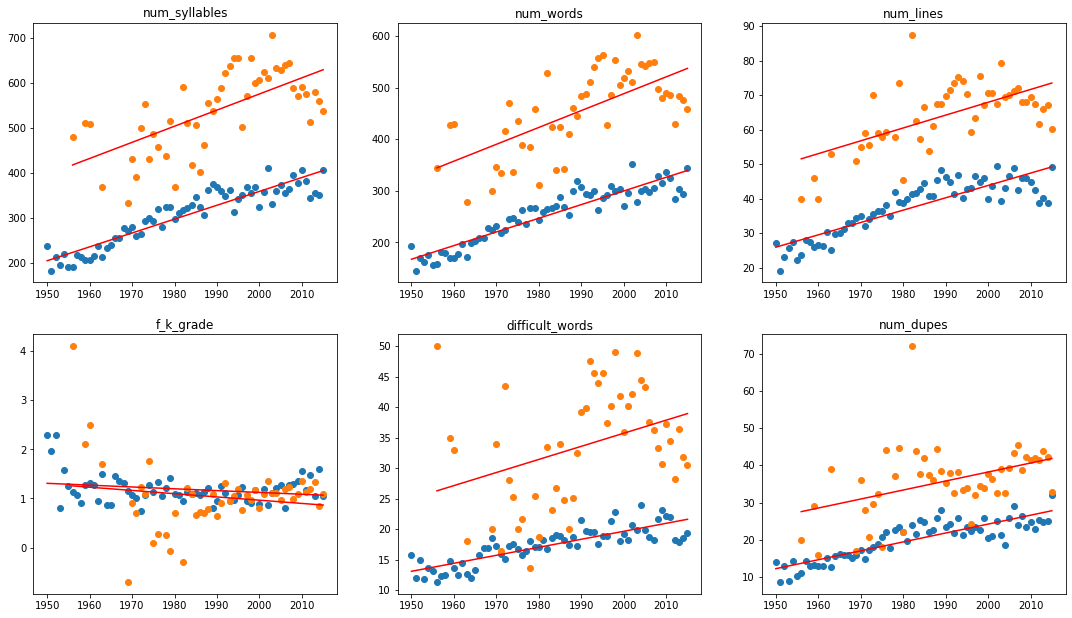

In [7]:
#Same plot functions as above but separated by cluster
def cluster_fit_line(dv, r, c, df, axs):
        X = np.array(df["year"].unique())
        Y = np.array(df.groupby("year")[dv].mean())
        theta = np.polyfit(X, Y, 1)
        y_line = theta[1] + theta[0] * X
        axs[r, c].scatter(X, Y)
        axs[r, c].plot(X, y_line, 'r')
        axs[r, c].set_title(dv)
        
def music_cluster_plots(columns, row, colnum, main_df, cluster1, cluster2):
    fig, axs = plt.subplots(nrows=row, ncols=colnum)
    fig.set_size_inches(18.5, 10.5)
    r = 0
    c = 0 
    for col in columns:
        if c <= colnum - 1:
            cluster_fit_line(col, r, c, cluster1, axs)
            cluster_fit_line(col, r, c, cluster2, axs)

            c += 1
        else:
            c = 0
            r += 1
            cluster_fit_line(col, r, c, cluster1, axs)
            cluster_fit_line(col, r, c, cluster2, axs)
            c += 1

slover = music_df[music_df['cluster']=='String Lover']
poet =  music_df[music_df['cluster']=='Poetic']

music_cluster_plots(text_columns, 2, 3, music_df, slover, poet)

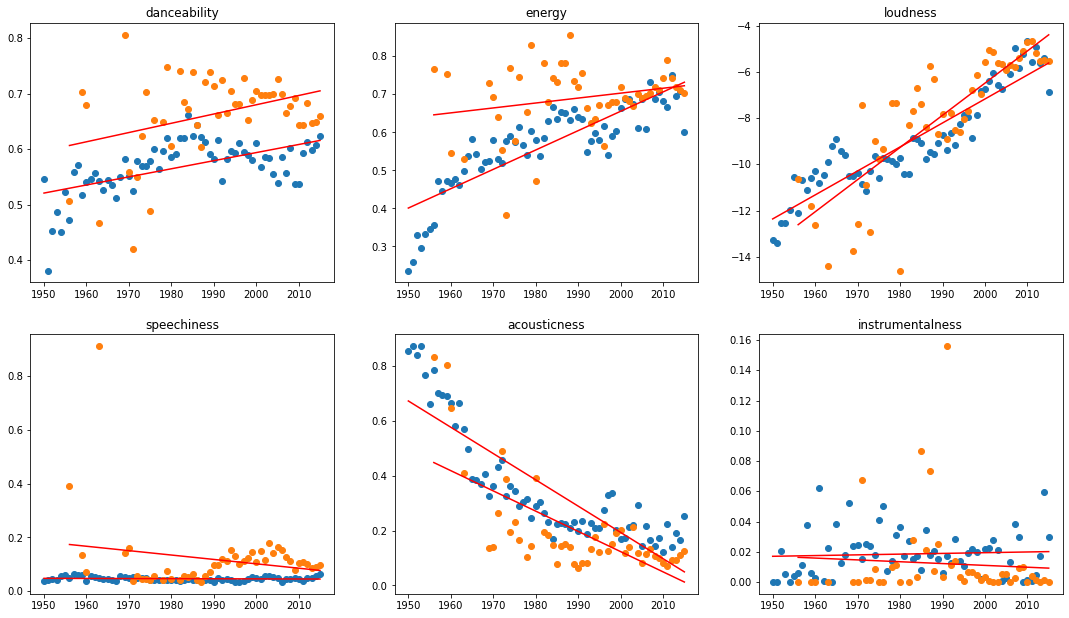

In [8]:
music_cluster_plots(music_columns, 2, 3, music_df, slover, poet)

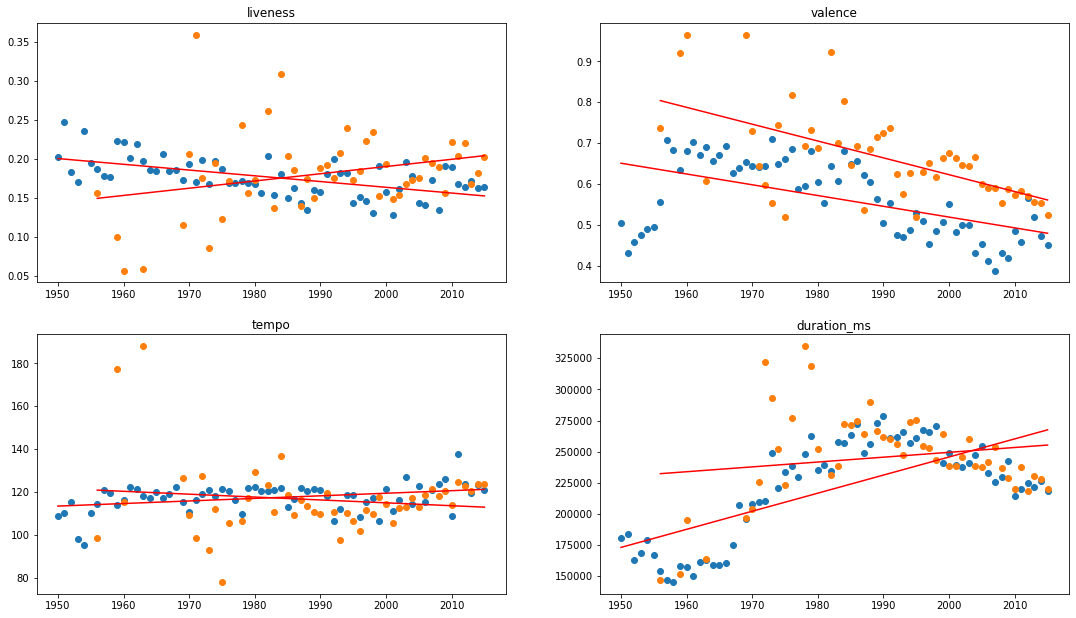

In [9]:
music_cluster_plots(music_columns_2, 2, 2, music_df, slover, poet)

### Correlation coefficients between clusters

In [17]:
#correlation coefficient between the two clusters across all dimensions
feats = ["num_syllables",
         "num_words",
         "num_lines",
         "f_k_grade",
         "difficult_words",
         "num_dupes",
         "danceability",
         "energy",
         "loudness",
         "mode",
         "speechiness",
         "acousticness",
         "instrumentalness",
         "liveness",
         "valence",
         "tempo",
         "duration_ms"]

corr_lst = []
corr_mean = 0

for col in feats:
    corr = slover.groupby("year")[col].mean().corr(poet.groupby("year")[col].mean())
    corr_lst.append((col, corr))
    corr_mean += corr / len(feats)

corr_lst.sort(key=lambda x: x[1])

for col, corr in corr_lst:
    print(f"Correlation coefficient for {col} is {corr:.3f}")
print(f"Average correlation coefficient is {corr_mean:.3f}")

Correlation coefficient for liveness is -0.190
Correlation coefficient for instrumentalness is -0.096
Correlation coefficient for f_k_grade is 0.075
Correlation coefficient for tempo is 0.111
Correlation coefficient for speechiness is 0.157
Correlation coefficient for energy is 0.296
Correlation coefficient for difficult_words is 0.301
Correlation coefficient for danceability is 0.362
Correlation coefficient for mode is 0.427
Correlation coefficient for valence is 0.489
Correlation coefficient for num_dupes is 0.510
Correlation coefficient for num_syllables is 0.562
Correlation coefficient for num_words is 0.597
Correlation coefficient for num_lines is 0.651
Correlation coefficient for duration_ms is 0.722
Correlation coefficient for loudness is 0.751
Correlation coefficient for acousticness is 0.891
Average correlation coefficient is 0.389


Instead of converging across all dimensions, both clusters tend to move in similar directions. The exceptions being observed for Flesh-Kincaid readability, energy, speechiness and valence. These features have poor to moderate correlations but their best fit lines appear to converge. 

## Comparison with all music

Finally, for added robustness of observation, I integrate a new dataset from Kaggle (https://www.kaggle.com/ironicninja/icm-problem-d) which contains data for all music between the years 1950 and 2020. I clip the range of the dataset to match that of music_df.csv and compare trends between the Billboard 100 and the broader music industry. If culture is becoming homogenized, the content of songs outside the top 100 should converge with that of the current most popular songs.

This new dataset only contains features extracted from the Spotify API and is missing features for the textual content. My analysis reveals that the best fit lines converge on energy, loudness, speechiness, instrumentalness, valence, and duration


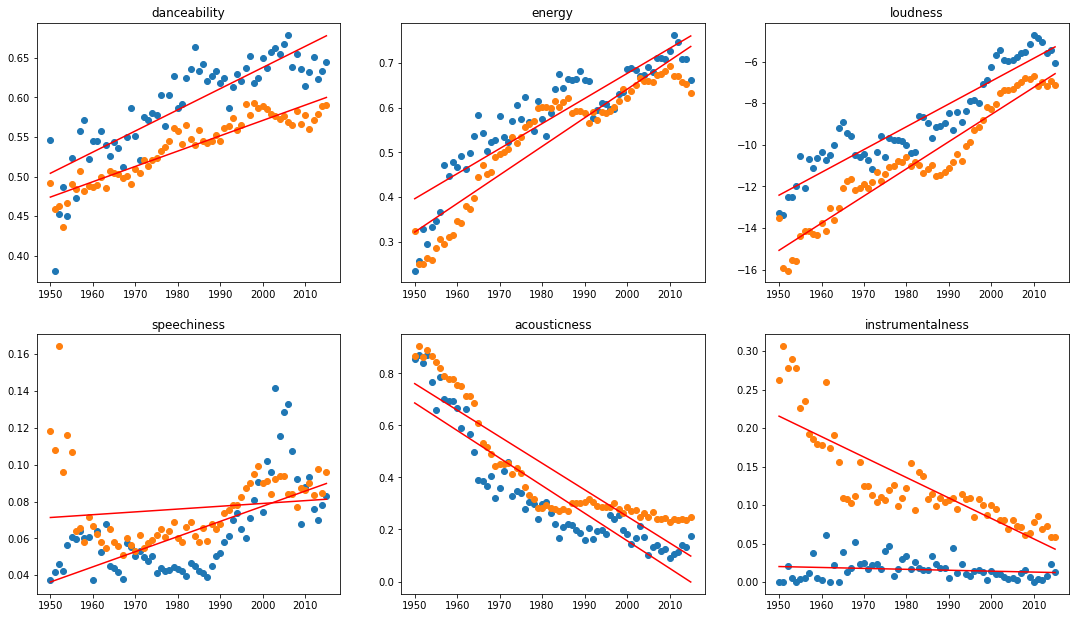

In [10]:
#this was the music_avg_df loaded earlier
music_cluster_plots(music_columns, 2, 3, music_df, music_df, music_avg_df)

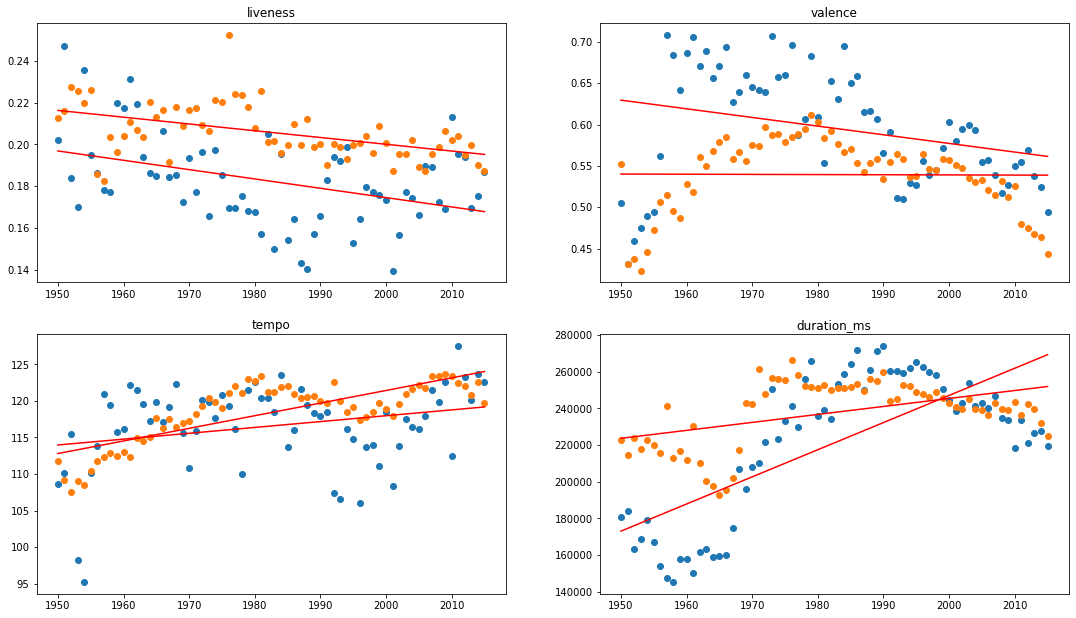

In [146]:
music_cluster_plots(music_columns_2, 2, 2, music_df, music_df, music_avg_df)

Overall, I conclude that the evidence for homogenization across all 3 analyses is strongest for flesch-kincaid readability, energy, and valence.  Valence denotes the musical positiveness in a track and energy denotes the intensity of music. Next, I analyse what could be responsible for these variations.

# Part 2: Developing A Social Theory

The decrease in flesch_kincaid and valence and increase in energy suggests that music is becoming easier to understand and increasingly negative, with sounds that are more intense. I argue that this homogenization is driven by an increase in social alienation. 

Under neoliberal capitalism, market forces work to promote atomization (Kotz, 2009). The individual is primarily viewed as a welfare-maximising consumer who achieves self-actualization through the purchase of goods and services at prices set by the invisible hand of the market. Norms of reciprocity are no longer needed to sustain complex social relations (Boykoff, 2011). Instead, individuals can have their every need met through tailor-made products. They are thus separated from the creative forces of imagination needed to produce truly original works grounded in self-actualization. Music is consequently commoditized both in its production and consumption (Peter, 2020).

The consumer’s value is defined by their purchasing power, which is constructed as being a product of their ability to work hard. Under neoliberal capitalism, the meritocratic system of advancement means that economic losers have only themselves to blame. Consequently, there is less incentive for individuals to cultivate compassion and empathy for the struggles faced by others around them (Wright, 2000). 

This process leads to feelings of social alienation as the cold logic of private property replaces the warmth of collective social connections. Consumers chase escapism and the short-term profit maximising incentives of the market serves to create content that is appealing to the base senses and easily digestible (Sharzer, 2021). High-energy songs become prioritised since they can be replayed endlessly in high profit-margin contexts such as concerts and night clubs. Simple lyrics allow these songs to be consumed effortlessly at these venues, memorized with ease to maximise replays and capture the attention of the consumer.

Escape from this cycle of consumption is only possible through introspection and the cultivation of solidarity with the wider community, understanding that material inequalities are not the by-product of natural laws but are rather the outcomes of an economic system specifically designed to enrich the few (Graeber, 2015). Unfortunately, the individual is kept from this realization through the very cultural commodities they consume which serve to reassure them that their discontent is the product of a world populated by other welfare-maximising individuals who cannot be relied upon. Human nature of the other is irredeemable while the self is the last bastion of all that is good in the world. The consequence is ultimately the production of homogenous songs designed to offer an escape whilst never fostering the empathy needed for true political consciousness. 

To summarise, neoliberal capitalism’s continued atomization of society and promotion of consumerism has led to weakened communal ties and less empathy for the most vulnerable members of society. Market logic has infiltrated the political consciousness of the consumer, leading to the idea that what separates economic winners and losers is the presence of a strong work ethic. 

Norms of reciprocity are eroded in favour of maximising self-interest. This unfortunately, leads to social alienation which consequently increases the demand for cultural commodities that distract the individual from the helplessness of their condition whilst attributing these feelings to the selfishness of others. The individual is thus shielded from having to perform the introspection necessary to free themselves from this cycle of consumption.


# Part 3: Testing Social Theory

If my theory explains this pattern, the replication of music-lyric legisigns that call attention to the suffering of others should be the central factor driving homogenization. On one hand, increasing individualism leads to less empathy for the plight of marginalised individuals. And on the other, this individualism leads to increased social alienation which in turn fuels a desire for escapism, represented by simple, high-energy, low-valence music that distracts the consumer and paints wider society as not worth engaging with. A direct linear relationship between a decline in empathy and homogenization, as operationalized by flesch-kincaid , valence, and energy levels will thus be observed.

To computationally test if this legisign relationship exists, I will use the moral foundations dictionary’s (MFD) (Frimmer et al, 2019), subset of words that indicate the moral virtue of caring. These are words like “kindness”, “compassion” and “empathy” used to symbolise feelings of connection to wider society (Frimer et al, 2019; Turino, 1999). I would expect that as the frequency of replication of these legisigns decreases, the homogenization of music increases. Music gradually loses its ability to tap on the notion communal ties and index feelings or experiences of solidarity, kinship and reciprocity. Songs consequently become increasingly geared towards offering the short-term pleasure of conspicuous consumption.

I build 3 linear-regression models that take the moral virtue of caring (care_pos) as the dependent variable and readability (f_k_grade), positivity (valence), and intensity (energy) as the respective independent variables. To control for the confounding impact of changing genre compositions, I take the year, cluster, speechiness, and interaction term between cluster and speechiness as controls. The results of my analysis are presented below.

In [18]:
#testing for words pertaining to political consciousness
mfd_dict = music.readDict("mfd2.0.dic")

In [19]:
lyrics = music_df['lyrics']

In [20]:
#Load in different dictionary categories that correspond to each moral foundation

def care_pos(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["care.virtue"] / mfd_counts[2]

def care_neg(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["care.vice"] / mfd_counts[2]

def fair_pos(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["fairness.virtue"] / mfd_counts[2]

def fair_neg(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["fairness.vice"] / mfd_counts[2]

def loyal_pos(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["loyalty.virtue"] / mfd_counts[2]

def loyal_neg(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["loyalty.vice"] / mfd_counts[2]

def auth_pos(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["authority.virtue"] / mfd_counts[2]

def auth_neg(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["authority.vice"] / mfd_counts[2]

def sanct_pos(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["sanctity.virtue"] / mfd_counts[2]

def sanct_neg(text, mfd_dict):    
    mfd_counts = music.wordCount(text, mfd_dict)    
    return mfd_counts[0]["sanctity.vice"] / mfd_counts[2]

In [21]:
#Create frequency counts for each moral foundation
care_pos = lyrics.apply(care_pos, args = [mfd_dict])
care_neg = lyrics.apply(care_neg, args = [mfd_dict])
fair_pos = lyrics.apply(fair_pos, args = [mfd_dict])
fair_neg = lyrics.apply(fair_neg, args = [mfd_dict])
loyal_pos = lyrics.apply(loyal_pos, args = [mfd_dict])
loyal_neg = lyrics.apply(loyal_neg, args = [mfd_dict])
auth_pos = lyrics.apply(auth_pos, args = [mfd_dict])
auth_neg = lyrics.apply(auth_neg, args = [mfd_dict])
sanct_pos = lyrics.apply(sanct_pos, args = [mfd_dict])
sanct_neg = lyrics.apply(sanct_neg, args = [mfd_dict])

In [22]:
#create new dataframe
df = pd.DataFrame({"Care_Pos": care_pos,
                   "Care_Neg": care_neg,
                   "Fair_Pos": fair_pos,
                   "Fair_Neg": fair_neg,
                   "Loyal_Pos": loyal_pos,
                   "Loyal_Neg": loyal_neg,
                   "Auth_Pos": auth_pos,
                   "Auth_Neg": auth_neg,
                   "Sanct_Pos": sanct_pos,
                   "Sanct_Neg": sanct_neg,
                   "Energy": music_df["energy"],
                   "F_K_Grade": music_df["f_k_grade"],
                   "Speechiness": music_df["speechiness"],
                   "Valence": music_df["valence"],
                   "Type": music_df["cluster"],
                   "year":music_df["year"],
                   "Year_Bin":music_df["year_bin"]})

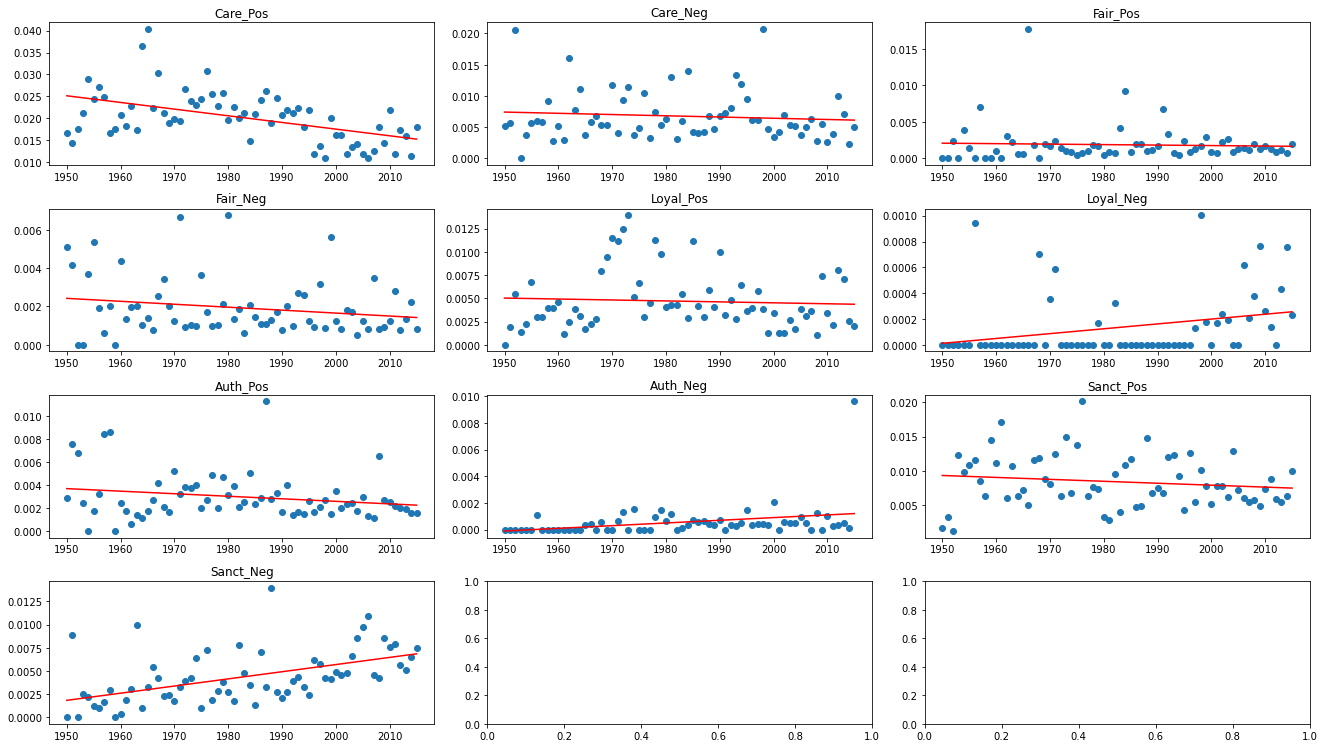

In [23]:
#plot time-series trends of moral foundations for exploration and visualization
moral_columns = list(df.columns[0:10])
music_plots(moral_columns, 4, 3, df)
plt.tight_layout()

In [24]:
#convert cluster encoding into a binary variable
def type_encoder(cluster):
    if cluster == "String Lover":
        return 1
    else:
        return 0
df["Type_Enc"] = df["Type"].apply(type_encoder)
df.head()

,Care_Pos,Care_Neg,Fair_Pos,Fair_Neg,Loyal_Pos,Loyal_Neg,Auth_Pos,Auth_Neg,Sanct_Pos,Sanct_Neg,Energy,F_K_Grade,Speechiness,Valence,Type,year,Year_Bin,Type_Enc
0,0.013605,0.013605,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.194,2.9,0.0325,0.339,String Lover,1950,1950s,1
1,0.050505,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.085,3.3,0.0389,0.181,String Lover,1950,1950s,1
2,0.014493,0.000000,0.0,0.014493,0.0,0.0,0.000000,0.0,0.0,0.0,0.163,2.9,0.0276,0.294,String Lover,1950,1950s,1
3,0.008264,0.008264,0.0,0.000000,0.0,0.0,0.008264,0.0,0.0,0.0,0.182,0.9,0.0357,0.474,String Lover,1950,1950s,1
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.273,6.0,0.0408,0.633,String Lover,1950,1950s,1


In [25]:
#Preprocess data for linear regression
#I decided on standardization after examining the distribution of each relevant feature

def standardization(value, column, df):
    mu = df[column].mean()
    std = df[column].std()
    return (value - mu)/std

df["Care_Pos_scaled"] = df["Care_Pos"].apply(standardization, args=["Care_Pos", df])
df["Energy_scaled"] = df["Energy"].apply(standardization, args=["Energy", df])
df["Speechiness_scaled"] = df["Speechiness"].apply(standardization, args=["Speechiness", df])
df["Valence_scaled"] = df["Valence"].apply(standardization, args=["Valence", df])
df["F_K_Grade_scaled"] = df["F_K_Grade"].apply(standardization, args=["F_K_Grade", df])

In [26]:
#Perform linear regressions
mod = smf.ols(formula='Energy_scaled ~ year + Care_Pos_scaled + Type_Enc + Speechiness_scaled + Type_Enc*Speechiness_scaled', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Energy_scaled   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     172.2
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          1.75e-166
Time:                        20:17:08   Log-Likelihood:                -5324.2
No. Observations:                4028   AIC:                         1.066e+04
Df Residuals:                    4022   BIC:                         1.070e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [27]:
mod = smf.ols(formula='Valence_scaled ~ year + Care_Pos_scaled + Type_Enc + Speechiness_scaled + Type_Enc*Speechiness_scaled', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Valence_scaled   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     77.23
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           1.54e-77
Time:                        20:17:15   Log-Likelihood:                -5530.4
No. Observations:                4028   AIC:                         1.107e+04
Df Residuals:                    4022   BIC:                         1.111e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [28]:
mod = smf.ols(formula='F_K_Grade_scaled ~ year + Care_Pos_scaled + Type_Enc + Speechiness_scaled + Type_Enc*Speechiness_scaled', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       F_K_Grade_scaled   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.921
Date:                Tue, 01 Mar 2022   Prob (F-statistic):             0.0123
Time:                        20:17:16   Log-Likelihood:                -5707.7
No. Observations:                4028   AIC:                         1.143e+04
Df Residuals:                    4022   BIC:                         1.147e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Part 4: Results Analysis

My linear regressions show that there is a statistically significant negative relationship between the energy and valence of songs in the Billboard 100 and the presence of music lyric legisigns that advocate for care of others. The r-squared values for both models are low at 0.175 and 0.086 respectively. 

The models control for year, cluster, speechiness, and the interaction between cluster and speechiness to prevent genre compositions of the Billboard 100 from confounding the results.I chose to control for cluster and speechiness due to prior research that attributed variations in Billboard 100 genre compositions to be driven by songs that either use more string instruments or spoken words such as rock and rap respectively (Mauch et al, 2015).

The coefficient for Energy ~ Care_Pos_Scaled is -0.0551 indicating that every 1 unit increase in the frequency of legisin replications is correlated with a -0.0551 unit drop in energy. The model with Valence as the dependent variable has an approximately similar coefficient of -0.0585.

The presence of statistical significance supports the predictions from my theory. However, these results are qualified by the relatively low R-squared values of 0.175 and 0.086 respectively. It is possible that much of the variation in homogenization is being driven by factors unincluded in the model or the presence of confounders is obscuring the full magnitude of my predictors’ impacts.

In the final model, F_K_Grade ~ Care_Pos_Scaled, the results are not statistically significant and the R-squared value of 0.002 indicates that much of the data is just noise with no predictive power. The simplification of song lyrics must be driven by alternative factors. 

All 3 linear regressions are also subject to high levels of multicollinearity between predictor variables. This weakens my results due to linear regression models' assumptions of linear independence amongst predictors. Additionally, the scatter plots in part 1 also suggest the possibility of a non-linear relationship between certain predictors. Further work is needed to improve upon the predictive power of these models.

Overall, I conclude that the market’s promotion of pessimistic and high intensity music is driven partially by a decline legisign replication indexing feelings of care for others. This decline in legisign replication means lyrics no longer contain sinsigns that symbolise these virtues or index prior experience with them. The result is homogenization of music to produce sounds that offer escapism from this loss of social connection (Turino, 1999). However, the same relationship cannot be observed between these declines in legisign replication and increased readability. Simpler lyrics might be the product of changes in other music-lyric legisign replications.


# Bibliography

Boykoff, J. (2011). The leaf blower, capitalism, and the atomization of everyday life. Capitalism Nature Socialism, 22(3), 95-113.

Frimer, J. A., Boghrati, R., Haidt, J., Graham, J., & Dehgani, M. (2019). Moral Foundations Dictionary for Linguistic Analyses 2.0. Unpublished manuscript.

Graeber, D. (2015). The utopia of rules: On technology, stupidity, and the secret joys of bureaucracy. Melville House.

Kotz, D. M. (2009). The financial and economic crisis of 2008: A systemic crisis of neoliberal capitalism. Review of radical political economics, 41(3), 305-317.

Mauch, M., MacCallum, R. M., Levy, M., & Leroi, A. M. (2015). The evolution of popular music: USA 1960–2010. Royal Society open science, 2(5), 150081.

Peter, M. J. (2020). New Ways of Monetization in a Commoditized Music Industry (Doctoral dissertation, University of Applied Sciences Darmstadt).

Sharzer, G. (2021). Late Escapism and Contemporary Neoliberalism: Alienation, Work and Utopia. Routledge.

Turino, T. (1999). Signs of imagination, identity, and experience: A Peircian semiotic theory for music. Ethnomusicology, 43(2), 221-255.

Wright, E. O. (2000). Working-class power, capitalist-class interests, and class compromise. American Journal of Sociology, 105(4), 957-1002.
